In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def latin_hypercube_sampling(n: int, samples: int) -> torch.Tensor:
    """
    Latin Hypercube Sampling
    """
    lhs = torch.rand(samples, n).to(device) # uniform distribution on the interval [0,1)
    for d in range(n):
        # For each sample, randomly select a point in the corresponding interval
        lhs[:, d] = (torch.randperm(samples).to(device) + 1.0 - lhs[:, d]) / samples
    return lhs

In [ ]:
# 1. Define the neural network
class AllanChanPINN(nn.Module):
    def __init__(self, layers):
        super(AllanChanPINN, self).__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.Tanh())
        self.model = nn.Sequential(*self.layers)

    def forward(self, x, t):
        u = self.model(torch.cat([x, t], dim=1))
        return u

In [ ]:
def compute_loss(model, x, t, u0, u1, x_for_initial_condition):

    x = x.clone().detach().requires_grad_(True).to(device)
    t = t.clone().detach().requires_grad_(True).to(device)
    u = model(x, t)

    # Use automatic differentiation to compute derivatives
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    # PDE residual
    f = u_t - 0.0001 * u_xx + 5 * (u ** 3) - 5 * u

    # Boundary conditions
    negative_ones = -1 * torch.ones_like(t, requires_grad=True)
    positive_ones = torch.ones_like(t, requires_grad=True)
    u_left = model(negative_ones, t)
    u_right = model(positive_ones, t)
    boundary_loss = torch.mean((u_left - u0)**2) + torch.mean((u_right - u1)**2)

    # Initial condition
    u_initial = model(x_for_initial_condition, torch.zeros_like(x_for_initial_condition))
    initial_condition = x_for_initial_condition ** 2 * torch.cos(torch.pi * x_for_initial_condition)
    # initial_condition = torch.sin(torch.pi * x_for_initial_condition)
    initial_loss = torch.mean((u_initial - initial_condition)**2)

    loss = torch.mean(f**2) + boundary_loss  + initial_loss
    return loss

In [ ]:
if __name__ == "__main__":
    layers = [2, 200, 200, 200, 200, 1]
    model = AllanChanPINN(layers).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Sample random points for training
    x = -1.0 + latin_hypercube_sampling(1, 10000) * 2.0
    t = latin_hypercube_sampling(1, 10000)

    # Boundary conditions
    u0 = torch.tensor([-1.0]).to(device)  # Just an example value
    u1 = torch.tensor([-1.0]).to(device)  # Just an example value

    # Initial condition: For simplicity, let's assume f(x) = sin(pi*x)
    x_for_initial_condition = -1.0 + latin_hypercube_sampling(1, 10000) * 2.0
    # initial_condition_values = torch.sin(torch.pi * x_for_initial_condition)

    lbfgs_optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * torch.finfo(torch.float64).eps,
    history_size=50,
    line_search_fn="strong_wolfe",
    )

    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x, t, u0, u1, x_for_initial_condition)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # torch.save(model, "/content/drive/MyDrive/COSC5655/Project/allan_chan_equation_model.pt")

Epoch 0, Loss: 2.0126609802246094
Epoch 100, Loss: 0.9032912850379944
Epoch 200, Loss: 0.5095988512039185
Epoch 300, Loss: 0.8765122890472412
Epoch 400, Loss: 0.06334102153778076
Epoch 500, Loss: 0.013081841170787811
Epoch 600, Loss: 0.009407302364706993
Epoch 700, Loss: 0.007754358928650618
Epoch 800, Loss: 0.0067023481242358685
Epoch 900, Loss: 0.005624351557344198
Epoch 1000, Loss: 0.004661358892917633
Epoch 1100, Loss: 0.003897625021636486
Epoch 1200, Loss: 0.003451832104474306
Epoch 1300, Loss: 0.003068840131163597
Epoch 1400, Loss: 0.002889288356527686
Epoch 1500, Loss: 0.00277963699772954
Epoch 1600, Loss: 0.0026870383881032467
Epoch 1700, Loss: 0.0026347460225224495
Epoch 1800, Loss: 0.00662929518148303
Epoch 1900, Loss: 0.0025052474811673164
Epoch 2000, Loss: 0.0024513883981853724
Epoch 2100, Loss: 0.0029500597156584263
Epoch 2200, Loss: 0.0025954905431717634
Epoch 2300, Loss: 0.0023616021499037743
Epoch 2400, Loss: 0.003784741973504424
Epoch 2500, Loss: 0.002863900735974312
E

In [ ]:
total_epochs = epochs  # Assuming epochs is defined elsewhere in your code

def closure():
    global total_epochs
    model.train()
    lbfgs_optimizer.zero_grad()
    loss = compute_loss(model, x, t, u0, u1, x_for_initial_condition)
    loss.backward()
    total_epochs += 1
    if total_epochs % 100 == 0:  # Use total_epochs instead of epoch
        print(f"Epoch {total_epochs}, Loss: {loss.item()}")
    return loss


In [ ]:
lbfgs_optimizer.step(closure)

Epoch 5100, Loss: 0.001601064344868064
Epoch 5200, Loss: 0.0014943426940590143
Epoch 5300, Loss: 0.00140242965426296
Epoch 5400, Loss: 0.0013487369287759066
Epoch 5500, Loss: 0.0013047674437984824
Epoch 5600, Loss: 0.0012632026337087154
Epoch 5700, Loss: 0.001222290564328432
Epoch 5800, Loss: 0.0011954084038734436
Epoch 5900, Loss: 0.0011660389136523008
Epoch 6000, Loss: 0.001127157243900001
Epoch 6100, Loss: 0.0010993452742695808
Epoch 6200, Loss: 0.0010656911181285977
Epoch 6300, Loss: 0.0010299808345735073
Epoch 6400, Loss: 0.0010051724966615438
Epoch 6500, Loss: 0.0009801792912185192
Epoch 6600, Loss: 0.0009670089930295944
Epoch 6700, Loss: 0.00095205451361835
Epoch 6800, Loss: 0.0009289889712817967
Epoch 6900, Loss: 0.0009135690052062273
Epoch 7000, Loss: 0.0008978705736808479
Epoch 7100, Loss: 0.0008801537333056331
Epoch 7200, Loss: 0.0008681142353452742
Epoch 7300, Loss: 0.0008578571141697466
Epoch 7400, Loss: 0.0008447818108834326
Epoch 7500, Loss: 0.0008339431369677186
Epoch 7

tensor(0.0017, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# allan_chan = torch.load("/content/drive/MyDrive/COSC5655/Project/allan_chan_equation_model.pt").to(device)
# allan_chan.eval()

len_eval = 1000

with torch.no_grad():
    x_eval = -1.0 + (torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)) * 2.0
    t_eval = torch.arange(1, len_eval + 1).to(device) / len_eval - (0.5 / len_eval)
    # Cartesian product
    all_points = torch.cartesian_prod(x_eval, t_eval).to(device) # (x, t)
    # torch.cartesian_prod: The behavior is similar to python’s itertools.product
    assert all_points.shape == (len_eval * len_eval, 2)
    all_results = model(all_points[:, 0:1], all_points[:, 1:2]).detach().squeeze()
    assert all_results.shape == torch.Size([len_eval * len_eval])

In [ ]:
import matplotlib.pyplot as plt

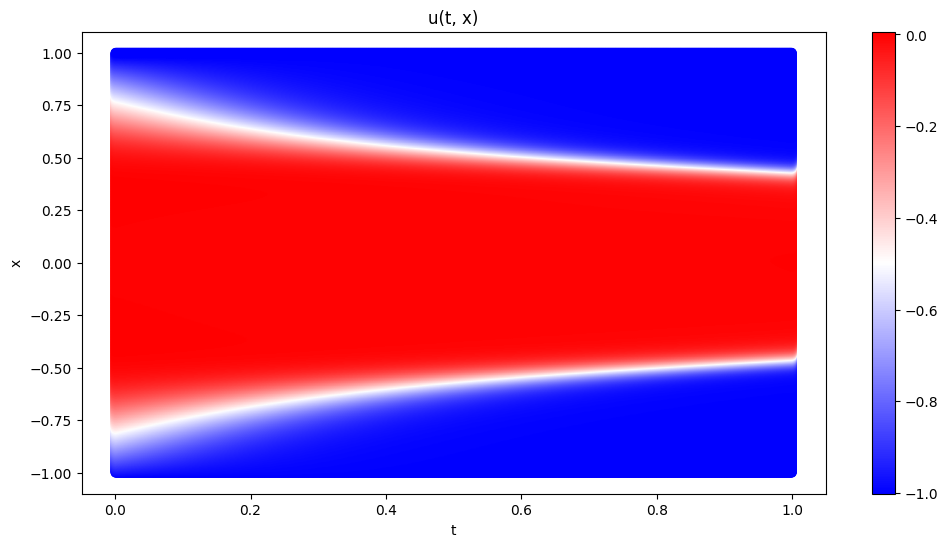

In [ ]:
plt.figure(figsize=(12, 6))

# Create scatter plot
plt.scatter(all_points[:, 1:2].squeeze().cpu(), all_points[:, 0:1].squeeze().cpu(), c=all_results.cpu(), cmap="bwr")

# Add a color bar
plt.colorbar()

# Add labels and title if needed
plt.xlabel('t')
plt.ylabel('x')
plt.title("u(t, x)")

# Show the plot
plt.show()

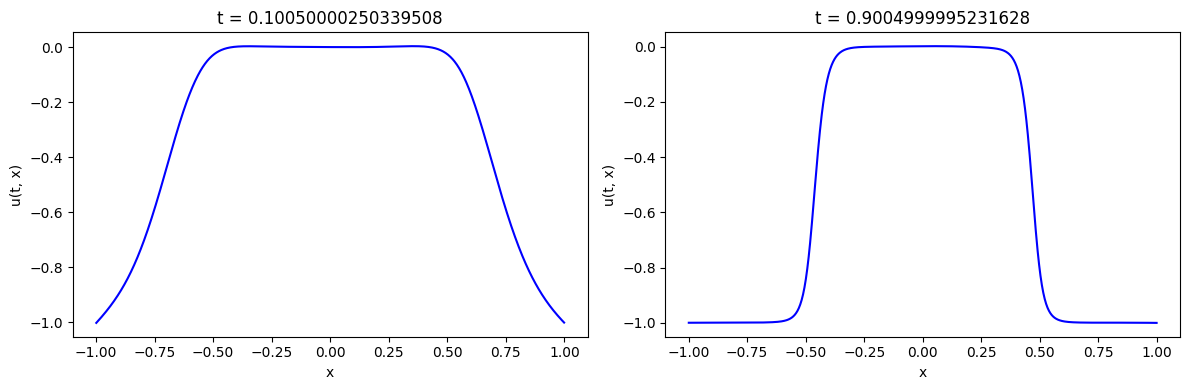

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

t_1 = int(0.1 * len_eval)
ax1.plot(x_eval.cpu(), all_results[torch.tensor([i + t_1 for i in range(0, len_eval * len_eval, len_eval)]).to(device)].cpu(), 'b-')
ax1.set_title('t = ' + str(float(t_eval[t_1])))
ax1.set_xlabel('x')
ax1.set_ylabel('u(t, x)')

# Second subplot
t_2 = int(0.9 * len_eval)
ax2.plot(x_eval.cpu(), all_results[torch.tensor([i + t_2 for i in range(0, len_eval * len_eval, len_eval)]).to(device)].cpu(), 'b-')
ax2.set_title('t = ' + str(float(t_eval[t_2])))
ax2.set_xlabel('x')
ax2.set_ylabel('u(t, x)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()